# Use skorch to do random Hyperparameter search for 5G RNA-seq data (single-task)
Given data that has been transformed into log-ratio TPMs, search the hyperparameter spaces of various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model

## *** Log(TPM) 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
from skorch import NeuralNetRegressor


## Load 5G data

In [4]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

log_data_filename = "data/XY_logTPM_opFilt.tsv"
XY_log = pd.read_csv(log_data_filename,sep='\t')

display(XY_log.head())

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.701712,5.159314,4.946232,4.544309,5.470820,5.489315,5.580793,5.425377,6.017577,5.002269,5.148210,5.063677
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.906680,5.431592,5.067489,4.241518,5.897951,6.022614,6.305779,5.935676,6.629400,5.448133,5.385163,5.449226
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,5.085045,4.772192,4.208764,4.205855,4.821135,4.878684,5.067555,4.849435,5.487238,4.416274,4.367689,4.534353
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,5.604311,5.064503,4.983838,4.084119,5.639215,5.606737,5.604730,5.671486,6.282482,5.381454,5.098383,5.404872
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.766245,4.767261,3.688497,3.422344,4.763636,4.687598,4.858654,4.698693,4.286940,4.525268,5.031830,5.103249


In [5]:
loc2seq = dict([(x,z) for (x,z) in XY_log[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


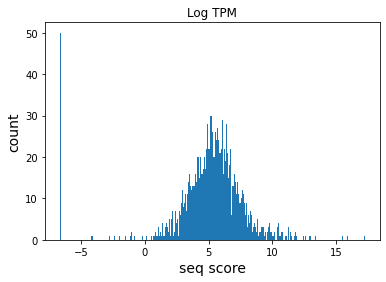

In [6]:
plt.hist(XY_log['highCu'].values,bins=500)
plt.title("score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("Log TPM")
plt.show()

In [7]:
for df in [XY_log]:
    df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
    df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])


In [8]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

## Load 5G seqs into data loaders

In [9]:
# LOG
log_full_train_df,log_test_df = tu.quick_split(XY_log)
log_train_df, log_val_df = tu.quick_split(log_full_train_df)

print(log_full_train_df.shape)
print(log_test_df.shape)
print(log_train_df.shape)
print(log_val_df.shape)

assert(log_train_df.shape[0] + log_val_df.shape[0] == log_full_train_df.shape[0])

(1763, 18)
(441, 18)
(1410, 19)
(353, 19)


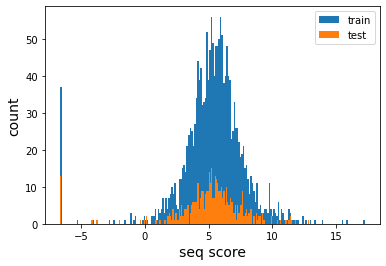

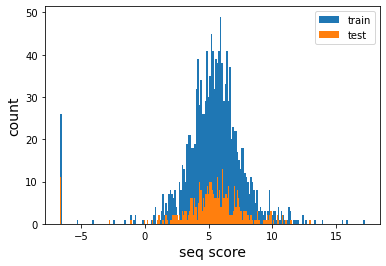

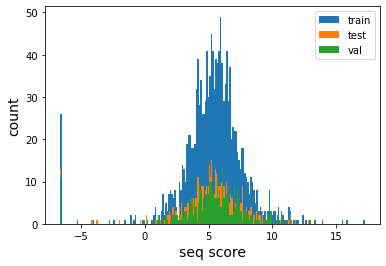

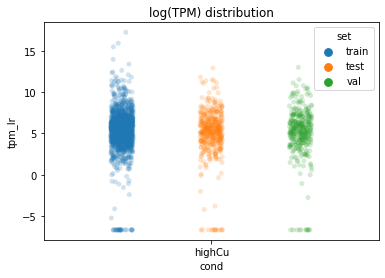

In [10]:
plot_train_test_hist(log_full_train_df, log_test_df,score_col='highCu',bins=200)
plot_train_test_hist(log_train_df, log_val_df,score_col='highCu',bins=200)

plot_train_test_hist(log_train_df, log_test_df, val_df=log_val_df,score_col='highCu',bins=200)
view_train_test_dist(log_train_df, log_test_df,["highCu"],"log(TPM)",val_df=log_val_df)


In [11]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [12]:
# Dfs for the full train/test split
log_final_dls = tu.build_dataloaders_single(
    log_full_train_df, 
    log_test_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu')

# Dfs from further spliting train into train and val
log_dls = tu.build_dataloaders_single(
    log_train_df, 
    log_val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu'
)

log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
log_ohe_train_dl,log_ohe_val_dl = log_dls['ohe']

In [13]:
len(log_kmer6_train_dl.dataset.kmers)

4096

## define basic single task models

In [14]:
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=5,
                 num_fc_nodes1=100,
                 num_fc_nodes2=10
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, num_fc_nodes1),
            nn.Linear(num_fc_nodes1, num_fc_nodes2),
            #nn.ReLU(inplace=True),
            nn.Linear(num_fc_nodes2, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

## training loop defs

In [100]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
    loss = loss_func(xb_out, yb.float())

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

def quick_loss_plot_simple(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,((train_data,test_data),label) in enumerate(data_label_list):
        # plot only 1 in every sparse_n points
        if sparse_n:
            train_data = [x for i,x in enumerate(train_data) if (i%sparse_n==0)]
            test_data = [x for i,x in enumerate(test_data) if (i%sparse_n==0)]
            
        plt.plot(train_data,'--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,'o-',color=f"C{i}", label=f"{label} Test",linewidth=3.0)
        

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

In [19]:
seq_len = len(log_train_df['upstream_region'].values[0])
model_cnn = DNA_CNN(
    seq_len,
)
model_cnn.to(DEVICE)

train_losses_cnn, \
test_losses_cnn = run_model(
    log_ohe_train_dl, 
    log_ohe_val_dl, 
    model_cnn, 
    lr=0.001,
    epochs=100,
)

# to plot loss
cnn_data_label = [((train_losses_cnn,test_losses_cnn),'CNN')]


0 9.858765337352374
1 9.603352993811157
2 9.182826673005188
3 12.409302063096346
4 8.77102617096293
5 8.697104077163567
6 8.705630016056741
7 9.059317113319807
8 9.648372628533469
9 10.827711029701124
10 8.721085186382867
11 9.650866740823805
12 8.516391989191936
13 8.536802464774242
14 8.992794631223166
15 8.419662493146513
16 8.70441578467912
17 9.183791009292387
18 8.346779681467808
19 9.387925655916122
20 9.166660200772812
21 8.320552053262425
22 8.356516078916554
23 12.45067524302107
24 9.564712343405056
25 10.285559402984532
26 9.069906242846091
27 8.225752245603134
28 8.12351464955057
29 8.268400931155716
30 8.09909367223637
31 9.763206009148876
32 11.560112342618343
33 11.672922758475242
34 9.983769997658879
35 8.675705334282462
36 8.3286808854122
37 8.551906836944667
38 25.45108195404831
39 8.41730296105231
40 8.188969128530356
41 12.540311543191796
42 17.227169096301026
43 22.524507101129203
44 8.229686820810983
45 8.196142339841503
46 9.285012307315643
47 8.335711165798285
4

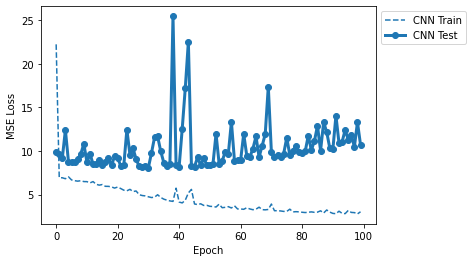

In [101]:
quick_loss_plot_simple(cnn_data_label)


## try fitting with skorch instead

In [45]:
def make_skorch_dfs(df,seq_col='seq',target_col='score'):
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    
    return ohe_seqs.float(), labels.float()

In [46]:
X, y = make_skorch_dfs(log_train_df, seq_col='upstream_region',target_col='highCu')

In [47]:
X.shape

torch.Size([1410, 300, 4])

In [48]:
y.shape

torch.Size([1410, 1])

In [49]:
net_regr = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
)

In [50]:
net_regr.fit(X, y)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       21.8181        7.7935  0.0357
      2        6.9539        7.0610  0.0363
      3        6.7819        7.0391  0.0354
      4        6.7366        7.0176  0.0357
      5        6.6917        6.9963  0.0358
      6        6.6471        6.9752  0.0355
      7        6.6025        6.9542  0.0352
      8        6.5578        6.9332  0.0355
      9        6.5129        6.9122  0.0353
     10        6.4676        6.8911  0.0350
     11        6.4217        6.8698  0.0351
     12        6.3753        6.8484  0.0351
     13        6.3280        6.8267  0.0351
     14        6.2798        6.8047  0.0349
     15        6.2306        6.7824  0.0351
     16        6.1802        6.7597  0.0346
     17        6.1286        6.7366  0.0345
     18        6.0755        6.7132  0.0344
     19        6.0210        6.6892  0.0352
     20        5.9648        6.6649  0.0345
     21        5.9069        6.6

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 31, kernel_size=(4, 5), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9176, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [77]:
y_pred = net_regr.predict(X[:5])
y_pred = torch.tensor(y_pred).to(DEVICE)


In [52]:
y[:5]

tensor([[6.3058],
        [5.0676],
        [4.8587],
        [3.1898],
        [6.1526]])

In [78]:
net_regr.get_loss(y_pred, y[:5])

tensor(1.7711, device='cuda:0')

In [70]:
y[:5]

tensor([[6.3058],
        [5.0676],
        [4.8587],
        [3.1898],
        [6.1526]])

In [74]:
torch.tensor(y_pred)

tensor([[5.5694],
        [6.4651],
        [4.6539],
        [5.4943],
        [5.1487]])

In [80]:
net_regr.train_split

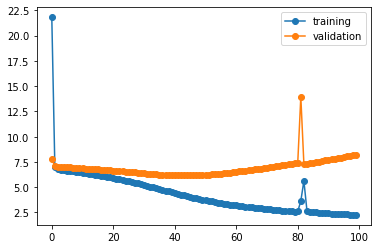

In [81]:
train_loss = net_regr.history[:, 'train_loss']
valid_loss = net_regr.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.legend()
plt.show()

In [85]:
len(net_regr.history)

100

In [98]:
skorch_label = [((net_regr.history[:, 'train_loss'], net_regr.history[:, 'valid_loss']), 'CNN')]

## now try random search with some params

In [106]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform


In [116]:
params = {
    'lr': [0.001, 0.0001],#loguniform(0.0001, 0.01)
    
    'module__num_filters': [16,32,64,128],
    'module__kernel_size': [4,8,16],
    'module__num_fc_nodes1': [10, 50, 100],
    #'optimizer__nesterov': [False, True],
}

In [117]:
loguniform(0.0001, 0.01)

In [118]:
search = RandomizedSearchCV(
    net_regr, 
    params, 
    n_iter=500, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=1,
    verbose=2
)

In [119]:
search.fit(X,y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 72 is smaller than n_iter=500. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       27.4967       21.0758  0.0361
      2       17.0550       13.2784  0.0343
      3       10.9623        9.2448  0.0340
      4        8.1342        7.6978  0.0345
      5        7.1500        7.2435  0.0340


[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  3.5min finished


      6        6.8723        7.1279  0.0348
      7        6.7952        7.0969  0.0341
      8        6.7658        7.0848  0.0340
      9        6.7468        7.0770  0.0342
     10        6.7302        7.0702  0.0342
     11        6.7141        7.0636  0.0338
     12        6.6982        7.0572  0.0344
     13        6.6824        7.0508  0.0344
     14        6.6667        7.0444  0.0338
     15        6.6511        7.0381  0.0338
     16        6.6355        7.0318  0.0345
     17        6.6200        7.0256  0.0338
     18        6.6045        7.0193  0.0340
     19        6.5890        7.0131  0.0338
     20        6.5737        7.0069  0.0338
     21        6.5583        7.0008  0.0338
     22        6.5430        6.9946  0.0345
     23        6.5277        6.9885  0.0339
     24        6.5125        6.9824  0.0338
     25        6.4973        6.9763  0.0337
     26        6.4821        6.9702  0.0338
     27        6.4670        6.9642  0.0348
     28        6.4518        6.9

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 31, kernel_size=(4, 5), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9176, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'lr': [0.001, 0.0001],
                                        'module__kernel_size': [4, 8, 16],
                                        'module__num_fc_nodes1': [10, 50, 100],
                                        'module__num_filters': [16, 32, 64,
                                                                128]},
                   random_state=1, scoring='neg_mean_squared_error', verbose=2)

In [124]:
search.best_estimator_.history

[{'batches': [{'train_loss': 31.544626235961914, 'train_batch_size': 128},
   {'train_loss': 32.63256072998047, 'train_batch_size': 128},
   {'train_loss': 30.88081932067871, 'train_batch_size': 128},
   {'train_loss': 28.72952651977539, 'train_batch_size': 128},
   {'train_loss': 21.743694305419922, 'train_batch_size': 128},
   {'train_loss': 25.821144104003906, 'train_batch_size': 128},
   {'train_loss': 30.289525985717773, 'train_batch_size': 128},
   {'train_loss': 21.318603515625, 'train_batch_size': 128},
   {'train_loss': 23.820728302001953, 'train_batch_size': 104},
   {'valid_loss': 16.236251831054688, 'valid_batch_size': 128},
   {'valid_loss': 25.826351165771484, 'valid_batch_size': 128},
   {'valid_loss': 21.51398277282715, 'valid_batch_size': 26}],
  'epoch': 1,
  'train_batch_count': 9,
  'valid_batch_count': 3,
  'dur': 0.03613090515136719,
  'train_loss': 27.49671971206124,
  'train_loss_best': True,
  'valid_loss': 21.07580402725977,
  'valid_loss_best': True},
 {'batc

In [125]:
search_label = [((search.best_estimator_.history[:, 'train_loss'], search.best_estimator_.history[:, 'valid_loss']), 'CNN')]

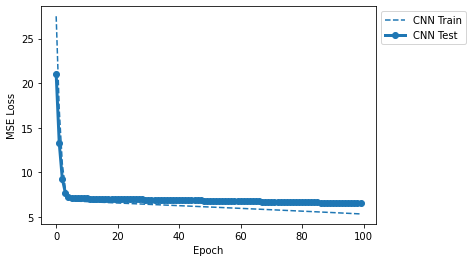

In [126]:
quick_loss_plot_simple(search_label)

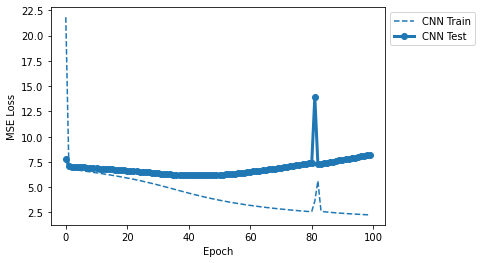

In [102]:
quick_loss_plot_simple(skorch_label)

In [129]:
search.cv_results_

{'mean_fit_time': array([7.01088428, 4.42818109, 3.42834489, 3.95703506, 3.03712384,
        3.20101452, 3.71479185, 4.5880541 , 3.09035261, 3.45978928,
        4.44256012, 6.00824229, 3.08462516, 3.10210633, 3.42395616,
        4.02246253, 3.06266077, 3.22416051, 3.74238586, 4.71368575,
        3.13223863, 3.43420053, 4.50079807, 5.94328046, 3.1670169 ,
        3.09290139, 3.45399404, 4.0903279 , 3.09330328, 3.19306374,
        3.74253345, 4.73407292, 3.20855832, 3.44187307, 4.47750322,
        6.02262719, 3.297544  , 3.11545897, 3.38717922, 3.92896573,
        3.14759533, 3.17649436, 3.6461819 , 4.54853042, 3.26868145,
        3.41961376, 4.47028526, 5.83333262, 3.36724361, 3.07715821,
        3.38571866, 3.98005795, 3.18610668, 3.1757439 , 3.67576528,
        4.58222818, 3.34459837, 3.43135699, 4.43138488, 5.84409332,
        3.50341439, 3.09344514, 3.45419073, 4.02507281, 3.22028303,
        3.18748426, 3.696721  , 4.64363424, 3.43957615, 3.39142656,
        4.49606482, 5.44134967]

In [130]:
results = pd.DataFrame(search.cv_results_)

In [134]:
results[['params','mean_test_score','rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
51,"{'module__num_filters': 128, 'module__num_fc_n...",-6.785219,1
55,"{'module__num_filters': 128, 'module__num_fc_n...",-6.817742,2
67,"{'module__num_filters': 128, 'module__num_fc_n...",-6.821124,3
50,"{'module__num_filters': 64, 'module__num_fc_no...",-6.821130,4
71,"{'module__num_filters': 128, 'module__num_fc_n...",-6.822330,5
...,...,...,...
19,"{'module__num_filters': 128, 'module__num_fc_n...",-11.241606,68
23,"{'module__num_filters': 128, 'module__num_fc_n...",-11.359755,69
31,"{'module__num_filters': 128, 'module__num_fc_n...",-11.716529,70
35,"{'module__num_filters': 128, 'module__num_fc_n...",-11.768762,71


In [144]:
search.

-1

ok, i think I'm seeing how to use skorch to automatically search through hyperparams...
* maybe visualize which types of params were better?
* series of distributions
* can I also change the optimizer? all the other parts I want to vary?
* then try with multitask?